<a href="https://colab.research.google.com/github/leoroman1/DL_project/blob/main/DL_project_stratification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"modality": {
	 "0": "FLAIR",
	 "1": "T1w",
	 "2": "t1gd",
	 "3": "T2w"
 },  
 "labels": {
	 "0": "background",
	 "1": "edema",
	 "2": "non-enhancing tumor",
	 "3": "enhancing tumour"
 }


# Google Drive connection

In [1]:
# connect to your drive with the dataset folder

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utils

## Zip file extraction

In [2]:
import os
import zipfile
from tqdm import tqdm

def extract_zip(zip_path, destination_path = "/content"):

    os.makedirs(destination_path, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        members = zip_ref.infolist()
        for member in tqdm(members, desc="Extracting", unit="file"):
            zip_ref.extract(member, path=destination_path)

    print(f"Extracted to: {destination_path}")


## Tar file extraction

In [3]:
import tarfile
from tqdm import tqdm
import os

def extract_tar(tar_path, destination_path = "/content"):

    os.makedirs(destination_path, exist_ok=True)

    with tarfile.open(tar_path, 'r:*') as tar:
        members = tar.getmembers()

        for member in tqdm(members, desc="Extracting", unit="file"):
            tar.extract(member, path=destination_path)

    print(f"Extracted to: {destination_path}")

## Zip and upload to drive

In [4]:
import shutil
import os

def save_zip_to_drive(folder_path, zip_name, destination_path = ''):

    zip_path = f"/content/{zip_name}.zip"

    shutil.make_archive(base_name=zip_path.replace('.zip', ''), format='zip', root_dir=folder_path)
    print(f"Zipped folder to: {zip_path}")

    destination_path = f"/content/drive/MyDrive/{destination_path}"
    os.makedirs(os.path.dirname(destination_path), exist_ok=True)
    shutil.move(zip_path, destination_path)
    print(f"Uploaded to Drive at: {destination_path}")


## Folder deletion from Colab

In [5]:
import shutil
import os

def delete_folders(folders_paths):

    for path in folders_paths:
        if os.path.exists(path):
            shutil.rmtree(path)
            print(f"Deleted: {path}")
        else:
            print(f"Not found: {path}")


## Folder renaming


In [6]:
import os

def rename_folder(folder_path, old_name, new_name):

    old_path_name = f"{folder_path}/{old_name}"
    new_path_name = f"{folder_path}/{new_name}"

    if os.path.exists(old_path_name):
        os.rename(old_path_name, new_path_name)
        print(f"{old_name} has been renamed to {new_name}")
    else:
        print(f"Folder not found: {old_path_name}")


## Copy files to another folder

In [7]:
import os
import shutil
from tqdm import tqdm

def copy_files_to_another_folder(source_folder, destination_folder, ids_list = 'all'):
    os.makedirs(destination_folder, exist_ok=True)

    if ids_list == 'all':
        files_to_copy = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]
    else:
        files_to_copy = [f"{id}.nii.gz" for id in ids_list]

    for filename in tqdm(files_to_copy, desc=f"Copying from {source_folder} to {destination_folder}", unit="file"):
        source_path = f"{source_folder}/{filename}"
        destination_path = f"{destination_folder}/{filename}"

        if not os.path.exists(source_path):
            print(f"Warning: {source_path} not found, skipping.")
            continue

        shutil.copy(source_path, destination_path)



## Apply a function to a folder

In [8]:
import os
import nibabel as nib
import numpy as np
import shutil
from tqdm import tqdm

def apply_function_to_folder(source_folder, destination_folder, function_to_apply):

    os.makedirs(destination_folder, exist_ok=True)

    for filename in tqdm(os.listdir(source_folder), desc=f"Applying function to files in {source_folder}", unit="file"):

        source_path = f"{source_folder}/{filename}"
        destination_path = f"{destination_folder}/{filename}"

        try:
            result_nii = function_to_apply(source_path)
            nib.save(result_nii, destination_path)
        except Exception as e:
            print(f"Error while processing file: {filename}: {e}")


# Data Exploration (to do)

## Plotting distributions

In [9]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Collect stats
stats = []

for fname in sorted(os.listdir(labels_folder)):
    if not fname.endswith('.nii.gz'):
        continue

    pid = fname.replace('.nii.gz', '')
    label_path = os.path.join(labels_folder, fname)

    label = nib.load(label_path).get_fdata()
    volume = np.sum(label > 0)
    class_counts = np.bincount(label.astype(np.int32).flatten(), minlength=4)

    stats.append({
        "filename": fname,
        "volume": volume,
        "class0": class_counts[0],
        "class1": class_counts[1],
        "class2": class_counts[2],
        "class3": class_counts[3]
    })

df = pd.DataFrame(stats)
df['volume_bin'] = pd.qcut(df['volume'], q=4, labels=False)  # Quartile binning



NameError: name 'labels_folder' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Histogram of total tumour volume per patient
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
sns.histplot(df["volume"], bins=30, kde=True, color="steelblue")
plt.title("Tumour-pixel distribution")
plt.xlabel("Voxel count (all classes > 0)")
plt.ylabel("Number of patients")

# 2) Box-and-whisker to flag volume outliers quickly
plt.subplot(1, 3, 2)
sns.boxplot(x=df["volume"], orient="h", color="salmon")
plt.title("Boxplot of tumour volume")
plt.xlabel("Voxel count")

# 3) Per-class voxel counts (log-scale → rare classes visible)
plt.subplot(1, 3, 3)
for cls, col in zip([1, 2, 3], ["class1", "class2", "class3"]):
    sns.scatterplot(x=np.arange(len(df)), y=df[col]+1, label=f"class {cls}")
plt.yscale("log")
plt.title("Per-class voxel counts (log scale)")
plt.xlabel("Patient index")
plt.ylabel("Voxels + 1")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:


train_ids, val_ids, test_ids = stratified_split_ids(images_folder, labels_folder)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nibabel as nib

def plot_distribution(labels_folder, ids_list, set_name):
    stats = []
    for pid in ids_list:
        label_path = os.path.join(labels_folder, f"{pid}.nii.gz")
        label = nib.load(label_path).get_fdata()
        volume = np.sum(label > 0)
        class_counts = np.bincount(label.astype(np.int32).flatten(), minlength=4)

        stats.append({
            "filename": pid,
            "volume": volume,
            "class0": class_counts[0],
            "class1": class_counts[1],
            "class2": class_counts[2],
            "class3": class_counts[3]
        })
    df = pd.DataFrame(stats)
    df['volume_bin'] = pd.qcut(df['volume'], q=4, labels=False)

    # Plot volume distribution
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(df['volume'], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'{set_name} Volume Distribution')
    plt.xlabel('Tumor Volume (voxels)')
    plt.ylabel('Number of cases')

    # Plot class presence counts
    plt.subplot(1, 2, 2)
    class_presence = [(df[f'class{i}'] > 0).sum() for i in range(4)]
    plt.bar([f'Class {i}' for i in range(4)], class_presence, color='lightcoral')
    plt.title(f'{set_name} Class Presence Count')
    plt.ylabel('Number of cases with >0 voxels')

    plt.tight_layout()
    plt.show()

# Example usage after splitting:
plot_distribution(labels_folder, train_ids, 'Train Set')
plot_distribution(labels_folder, val_ids, 'Validation Set')
plot_distribution(labels_folder, test_ids, 'Test Set')


# Preprocessing functions



## Retrieve data IDs to use

In [10]:
import os
import json

def retrieve_ids_list(dataset_json_path):

    with open(dataset_json_path, 'r') as f:
        data = json.load(f)

    data_ids = []

    for entry in data['training']:
        image_path = entry['image']
        filename = os.path.basename(image_path)
        image_id = filename.replace('.nii.gz', '')
        data_ids.append(image_id)

    print("Number of IDs extracted:", len(data_ids))
    print("First 5 IDs of the list:", data_ids[:5])
    return data_ids





## Cropping samples


In [11]:
import os
import nibabel as nib
import numpy as np
from tqdm import tqdm

import nibabel as nib

import nibabel as nib

def crop_file(file_path, height_range=(46, 190), width_range=(26, 202), depth_range=(6, 150)):

    nii_file = nib.load(file_path)
    data = nii_file.get_fdata()

    h_start, h_end = height_range
    w_start, w_end = width_range
    d_start, d_end = depth_range

    if data.ndim == 4:
        cropped_data = data[h_start:h_end, w_start:w_end, d_start:d_end, :]
    elif data.ndim == 3:
        cropped_data = data[h_start:h_end, w_start:w_end, d_start:d_end]

    cropped_nii = nib.Nifti1Image(cropped_data, affine=nii_file.affine, header=nii_file.header)
    return cropped_nii





## Split samples with almost only background

In [12]:
import os
import nibabel as nib
import numpy as np
from tqdm import tqdm

def split_samples_by_presence_of_tumor_labels(labels_folder, threshold=0.01):

    above_threshold_ids = []
    below_threshold_ids = []

    for id in tqdm(os.listdir(labels_folder), desc="Splitting samples by tumor labels presence: ", unit="file"):

        label_path = f"{labels_folder}/{id}"
        label_nii = nib.load(label_path)
        label_data = label_nii.get_fdata().astype(np.uint8)

        total_labels = np.prod(label_data.shape)
        non_background_labels = np.sum(label_data > 0)
        ratio = non_background_labels / total_labels

        id = id.split('.')[0]
        if ratio >= threshold:
            above_threshold_ids.append(id)
        else:
            below_threshold_ids.append(id)

    print(f"{len(above_threshold_ids)} samples above the threshold")
    print(f"{len(below_threshold_ids)} samples below the threshold")

    return above_threshold_ids, below_threshold_ids




## Keep only 2 modalities

In [13]:
import os
import nibabel as nib
import numpy as np
import shutil
from tqdm import tqdm

def extract_modalities(image_path, channels=[0, 2]):

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"{image_path} does not exist")

    image_nii = nib.load(image_path)
    image_data = image_nii.get_fdata()
    selected_channels_data = image_data[:, :, :, channels]

    return nib.Nifti1Image(selected_channels_data, affine=image_nii.affine, header=image_nii.header)



## Normalization

In [14]:
import nibabel as nib
import numpy as np

def normalize_image(image_path):

    image_nii = nib.load(image_path)
    image = image_nii.get_fdata()

    normalized_image = np.zeros_like(image)

    for i in range(image.shape[-1]):
        channel_data = image[..., i]
        brain_region = channel_data[channel_data > 0]

        if brain_region.size == 0:
            normalized_image[..., i] = channel_data
        else:
            mean = brain_region.mean()
            std = brain_region.std()
            normalized_image[..., i] = (channel_data - mean) / (std + 1e-5)

    return nib.Nifti1Image(normalized_image, affine=image_nii.affine, header=image_nii.header)



# Preprocessing execution

In [ ]:
# Extract dataset tar
dataset_path = '/content/drive/MyDrive/Task01_BrainTumour.tar'
extract_tar(dataset_path)

# Main folders now
images_folder = '/content/Task01_BrainTumour/imagesTr'
labels_folder = '/content/Task01_BrainTumour/labelsTr'

In [ ]:
# Select IDs from the JSON
dataset_json_path = '/content/Task01_BrainTumour/dataset.json'
data_ids = retrieve_ids_list(dataset_json_path)

# Copy selected images to another folder
images_destination_folder = '/content/selected_imagesTr'
copy_files_to_another_folder(images_folder, images_destination_folder, data_ids)

# Copy selected labels to another folder
labels_destination_folder = '/content/selected_labelsTr'
copy_files_to_another_folder(labels_folder, labels_destination_folder, data_ids)

# Delete dataset folder to free space
colab_dataset_path = '/content/Task01_BrainTumour'
delete_folders([colab_dataset_path])

# Main folders now
images_folder = images_destination_folder
labels_folder = labels_destination_folder


In [ ]:
# Crop images
images_destination_folder = '/content/cropped_imagesTr'
apply_function_to_folder(images_folder, images_destination_folder, crop_file)

# Crop labels
labels_destination_folder = '/content/cropped_labelsTr'
apply_function_to_folder(labels_folder, labels_destination_folder, crop_file)

# Delete folders to free space
delete_folders([images_folder, labels_folder])

# Main folders now
images_folder = images_destination_folder
labels_folder = labels_destination_folder


In [ ]:
# Split samples with almost no tumor labels from others (could be used later)
above_threshold_ids, below_threshold_ids = split_samples_by_presence_of_tumor_labels(labels_folder)

# Put relevant images in another folder
rel_images_destination_folder = '/content/relevant_samples_imagesTr'
copy_files_to_another_folder(images_folder, rel_images_destination_folder, above_threshold_ids)

# Put relevant labels in another folder
rel_labels_destination_folder = '/content/relevant_samples_labelsTr'
copy_files_to_another_folder(labels_folder, rel_labels_destination_folder, above_threshold_ids)

# Put non relevant images in another folder
non_rel_images_destination_folder = '/content/non_relevant_samples/imagesTr'
copy_files_to_another_folder(images_folder, non_rel_images_destination_folder, below_threshold_ids)

# Put non relevant labels in another folder
non_rel_labels_destination_folder = '/content/non_relevant_samples/labelsTr'
copy_files_to_another_folder(labels_folder, non_rel_labels_destination_folder, below_threshold_ids)

# Upload non relevant samples zip to drive
non_rel_samples_path = '/content/non_relevant_samples'
save_zip_to_drive(non_rel_samples_path, 'non_relevant_samples')


# Delete past folders to free space
delete_folders([images_folder, labels_folder, non_rel_samples_path])

# Main folders now
images_folder = rel_images_destination_folder
labels_folder = rel_labels_destination_folder


In [ ]:
# Keep just FLAIR and t1gt modalities
images_destination_folder = '/content/2channel_imagesTr'
apply_function_to_folder(images_folder, images_destination_folder, extract_modalities)

# Delete image folder to free space
delete_folders([images_folder])

# Main folders now
images_folder = images_destination_folder
labels_folder = labels_folder

In [ ]:
# Normalize per sample
images_destination_folder = '/content/normalized_imagesTr'
apply_function_to_folder(images_folder, images_destination_folder, normalize_image)

# Delete image folder to free space
delete_folders([images_folder])

# Main folders now
images_folder = images_destination_folder
labels_folder = labels_folder

In [ ]:
# Move images and labels to a single final folder
final_images_destination_folder = '/content/preprocessed_dataset/imagesTr'
final_labels_destination_folder = '/content/preprocessed_dataset/labelsTr'
copy_files_to_another_folder(images_folder, final_images_destination_folder)
copy_files_to_another_folder(labels_folder, final_labels_destination_folder)

# Upload zip of final dataset to Drive
final_dataset_path = '/content/preprocessed_dataset'
save_zip_to_drive(final_dataset_path, 'preprocessed_dataset')

# Delete folders to free space
delete_folders([images_folder, labels_folder, final_dataset_path])


# Extract preprocessed dataset


In [ ]:
# Unzip preprocessed dataset from Drive to Colab
preprocessed_dataset_path = '/content/drive/MyDrive/preprocessed_dataset.zip'
extract_zip(preprocessed_dataset_path)

# Main folder
images_folder = '/content/imagesTr'
labels_folder = '/content/labelsTr'

Extracting:  94%|█████████▎| 778/832 [00:35<00:12,  4.17file/s]

# Model setup functions


## Split IDs into Train, Validaton and Test

### Random

In [ ]:
import os
from sklearn.model_selection import train_test_split

def split_ids_into_train_val_test(images_folder, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1, seed=1748):

    ids = [f.replace('.nii.gz', '') for f in os.listdir(images_folder)]
    ids.sort()

    train_ids, val_test_ids = train_test_split(ids, test_size=(1 - train_ratio), random_state=seed)

    validation_size = validation_ratio / (validation_ratio + test_ratio)
    validation_ids, test_ids = train_test_split(val_test_ids, test_size=(1 - validation_size), random_state=seed)

    print(f"Total IDs count: {len(ids)}")
    print(f"Train IDs count: {len(train_ids)}")
    print(f"Validation IDs count: {len(validation_ids)}")
    print(f"Test IDs count: {len(test_ids)}")

    return train_ids, validation_ids, test_ids


### Stratification

In [ ]:
import os
import nibabel as nib
import pandas as pd
from sklearn.model_selection import train_test_split

def stratified_split_ids(images_folder, labels_folder,
                         train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1,
                         seed=1748):
    # Gather label stats for stratification
    stats = []
    for fname in sorted(os.listdir(labels_folder)):
        if not fname.endswith('.nii.gz'):
            continue
        pid = fname.replace('.nii.gz', '')
        label_path = os.path.join(labels_folder, fname)
        label = nib.load(label_path).get_fdata()
        volume = np.sum(label > 0)
        class_counts = np.bincount(label.astype(np.int32).flatten(), minlength=4)

        stats.append({
            "filename": pid,
            "volume": volume,
            "class0": class_counts[0],
            "class1": class_counts[1],
            "class2": class_counts[2],
            "class3": class_counts[3]
        })

    df = pd.DataFrame(stats)
    # Allow dropping duplicates if bins are not unique
    df['volume_bin'] = pd.qcut(df['volume'], q=4, labels=False, duplicates='drop')

    def make_strat_label(row):
        c1 = int(row['class1'] > 0)
        c2 = int(row['class2'] > 0)
        c3 = int(row['class3'] > 0)
        # Include volume_bin in the stratification label
        return f"{row['volume_bin']}_{c1}{c2}{c3}"

    df['strat_label'] = df.apply(make_strat_label, axis=1)

    # Identify rare groups with less than 2 samples
    counts = df['strat_label'].value_counts()
    rare_groups = counts[counts < 2].index.tolist()

    # Print rare group samples before reassignment
    print("Samples in rare stratification groups (less than 2 samples):")
    for rare_group in rare_groups:
        rare_samples = df[df['strat_label'] == rare_group]['filename'].tolist()
        print(f"Group '{rare_group}': {rare_samples}")

    # Merge rare groups into 'rare' to avoid stratify errors initially
    df['strat_label'] = df['strat_label'].apply(lambda x: 'rare' if x in rare_groups else x)

    # Recalculate counts after merging rare groups
    updated_counts = df['strat_label'].value_counts()
    print("Stratification group counts after initial merging:")
    print(updated_counts)

    # Handle single-member groups after merging
    single_member_groups = updated_counts[updated_counts < 2].index.tolist()
    if single_member_groups:
        print(f"Found single-member stratification groups after merging: {single_member_groups}. Reassigning these samples.")
        # Find the largest group (excluding single-member ones)
        largest_group = updated_counts[~updated_counts.index.isin(single_member_groups)].idxmax()
        print(f"Largest group is: {largest_group}. Reassigning single samples to this group.")

        for group_label in single_member_groups:
            single_sample_id = df[df['strat_label'] == group_label]['filename'].iloc[0]
            df.loc[df['filename'] == single_sample_id, 'strat_label'] = largest_group
            print(f"Reassigned sample {single_sample_id} from group '{group_label}' to group '{largest_group}'.")

        # Final counts after reassignment
        final_counts = df['strat_label'].value_counts()
        print("Stratification group counts after reassignment:")
        print(final_counts)

    ids = df['filename'].values
    strat_labels = df['strat_label'].values

    # Split off test set first
    trainval_ids, test_ids, trainval_strat, test_strat = train_test_split(
        ids, strat_labels, test_size=test_ratio, random_state=seed, stratify=strat_labels)

    # Adjust validation ratio relative to train+val set size
    val_ratio_adjusted = validation_ratio / (train_ratio + validation_ratio)

    train_ids, val_ids, train_strat, val_strat = train_test_split(
        trainval_ids, trainval_strat, test_size=val_ratio_adjusted, random_state=seed, stratify=trainval_strat)

    print(f"Total IDs count: {len(ids)}")
    print(f"Train IDs count: {len(train_ids)}")
    print(f"Validation IDs count: {len(val_ids)}")
    print(f"Test IDs count: {len(test_ids)}")

    return list(train_ids), list(val_ids), list(test_ids)


## Extract input dimensions

In [ ]:
import os
import nibabel as nib

def get_input_size(images_folder):

    first_image = sorted(os.listdir(images_folder))[0]
    image_path = os.path.join(images_folder, first_image)

    image_data = nib.load(image_path).get_fdata()

    height, width, depth, modalities = image_data.shape

    print(f"Height: {height}, Width: {width}, Depth: {depth}, Modalities: {modalities}")

    return height, width, depth, modalities


# U-Net model

In [ ]:
from tensorflow.keras import layers, models

def conv_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    return x

input_layer = layers.Input(shape=(144, 176, 2))

# Encoder (Downsampling path)
c1 = conv_block(input_layer, 16)
p1 = layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)
p2 = layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)
p3 = layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)
p4 = layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)

# Decoder (Upsampling path)
u6 = layers.UpSampling2D((2, 2))(c5)
u6 = layers.Concatenate()([u6, c4])
c6 = conv_block(u6, 128)

u7 = layers.UpSampling2D((2, 2))(c6)
u7 = layers.Concatenate()([u7, c3])
c7 = conv_block(u7, 64)

u8 = layers.UpSampling2D((2, 2))(c7)
u8 = layers.Concatenate()([u8, c2])
c8 = conv_block(u8, 32)

u9 = layers.UpSampling2D((2, 2))(c8)
u9 = layers.Concatenate()([u9, c1])
c9 = conv_block(u9, 16)

output_layer = layers.Conv2D(4, (1, 1), activation='softmax')(c9)

# Data generator for slices

## Augmentation pipeline


In [ ]:
import os, numpy as np, nibabel as nib
from tensorflow.keras.utils import Sequence
from scipy import ndimage   # for rotation

class BrainTumor2DSliceGenerator(Sequence):
    def __init__(self,
                 images_folder,
                 labels_folder,
                 ids,
                 batch_size=36,
                 slice_step=8,
                 shuffle=True,
                 augment=False):
        self.images_folder = images_folder
        self.labels_folder = labels_folder
        self.batch_size    = batch_size
        self.slice_step    = slice_step
        self.shuffle       = shuffle
        self.augment       = augment          # flag to turn aug on/off
        self.ids           = sorted(ids)

        self.index_list = self._create_index_list()
        if self.shuffle:
            np.random.shuffle(self.index_list)

    # ------------------------------------------------------------------
    def _create_index_list(self):
        index_list = []
        for pid in self.ids:
            vol_path = os.path.join(self.images_folder, f"{pid}.nii.gz")
            depth = nib.load(vol_path).shape[2]
            index_list.extend([(pid, z) for z in range(0, depth, self.slice_step)])
        return index_list

    # ------------------------------------------------------------------
    def __len__(self):
        return int(np.ceil(len(self.index_list) / self.batch_size))

    # ------------------------------------------------------------------
    def __getitem__(self, idx):
        batch_specs = self.index_list[idx*self.batch_size:(idx+1)*self.batch_size]
        X_list, y_list = [], []

        for pid, z in batch_specs:
            img = nib.load(os.path.join(self.images_folder, f"{pid}.nii.gz")).get_fdata(dtype=np.float32)
            msk = nib.load(os.path.join(self.labels_folder,  f"{pid}.nii.gz")).get_fdata()

            img_slice = img[:, :, z, :]      # (144, 176, 2)
            msk_slice = msk[:, :, z]         # (144, 176)

            # ---------------- augmentation -------------------------
            if self.augment:
                # horizontal flip
                if np.random.rand() < 0.5:
                    img_slice = np.flip(img_slice, 1)
                    msk_slice = np.flip(msk_slice, 1)

                # vertical flip
                if np.random.rand() < 0.5:
                    img_slice = np.flip(img_slice, 0)
                    msk_slice = np.flip(msk_slice, 0)

                # small rotation (keeps size)
                if np.random.rand() < 0.3:
                    angle = np.random.uniform(-15, 15)
                    for c in range(img_slice.shape[-1]):
                        img_slice[..., c] = ndimage.rotate(
                            img_slice[..., c], angle,
                            reshape=False, order=1, mode='nearest')
                    msk_slice = ndimage.rotate(
                        msk_slice, angle,
                        reshape=False, order=0, mode='nearest')

                # light gaussian noise
                if np.random.rand() < 0.3:
                    img_slice += np.random.normal(0, 0.01, img_slice.shape).astype(np.float32)

            X_list.append(img_slice.astype(np.float32))   # (H,W,2)
            y_list.append(msk_slice.astype(np.int32))     # (H,W)

        X_batch = np.stack(X_list, axis=0)  # (B, H, W, 2)
        y_batch = np.stack(y_list, axis=0)  # (B, H, W)   ← no extra dim!

        return X_batch, y_batch

    # ------------------------------------------------------------------
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.index_list)



# Loss functions

## Sparse Categorical Class Entropy Loss

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import Dice, SparseCategoricalCrossentropy

scce_loss = SparseCategoricalCrossentropy(from_logits=False)

## Dice Loss

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import Dice

number_of_classes = 4

def dice_loss(y_true, y_pred):

    y_true = tf.cast(y_true, tf.int32)
    y_true_one_hot = tf.one_hot(y_true, depth=number_of_classes)

    return Dice(axis=(1, 2))(y_true_one_hot, y_pred)

## Combo Losses

### Sparse Categorical Cross Entropy Loss and Dice Loss

In [ ]:
def combo_scce_dice_loss(y_true, y_pred, alpha=0.5):
    scce_loss_value = scce_loss(y_true, y_pred)
    dice_loss_value = dice_loss(y_true, y_pred)
    return alpha * scce_loss_value + (1 - alpha) * dice_loss_value


# Metrics

## Intersection over Union

In [ ]:
from tensorflow.keras.metrics import MeanIoU

number_of_classes = 4

iou_metric = MeanIoU(
    num_classes=number_of_classes,
    sparse_y_true=True,
    sparse_y_pred=False,
    name="IoU"
)

## F1 Score per class

In [ ]:
import tensorflow as tf

def f1_score_per_class_fn(class_id):
    @tf.function  # ensures TensorFlow traces once and reuses
    def f1_score(y_true, y_pred):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.cast(y_true, tf.int32)

        pred_labels = tf.equal(y_pred, class_id)
        true_labels = tf.equal(y_true, class_id)

        tp = tf.reduce_sum(tf.cast(pred_labels & true_labels, tf.float32))
        fp = tf.reduce_sum(tf.cast(pred_labels & ~true_labels, tf.float32))
        fn = tf.reduce_sum(tf.cast(~pred_labels & true_labels, tf.float32))

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)

        return f1
    return f1_score


f1_score_edema = f1_score_per_class_fn(1)
f1_score_non_enhancing_tumor = f1_score_per_class_fn(2)
f1_score_enhancing_tumor = f1_score_per_class_fn(3)


# Callbacks


## Drive checkpoint saver

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/checkpoints/dice/epoch_{epoch:02d}.keras',  # customize as needed
    save_freq='epoch',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

## Reduce LR on Plateau

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


# Model setup

## Training from scratch

### Split IDs randomly

In [ ]:
# Split IDs into train, test and validation (default ratio is 80, 10, 10)
train_ids, validation_ids, test_ids = split_ids_into_train_val_test(images_folder)


Total IDs count: 415
Train IDs count: 332
Validation IDs count: 41
Test IDs count: 42


In [ ]:
import numpy as np

# Save to a file in your Google Drive (adjust path as needed)
np.savez('/content/drive/MyDrive/random_split_ids.npz',
         train_ids=train_ids,
         validation_ids=validation_ids,
         test_ids=test_ids)

### Split IDs with stratification

In [ ]:
# Split IDs with stratification into train, test and validation (default ratio is 80, 10, 10)
train_ids, validation_ids, test_ids = stratified_split_ids(images_folder, labels_folder)

In [ ]:
import numpy as np

# Save to a file in your Google Drive (adjust path as needed)
np.savez('/content/drive/MyDrive/stratified_split_ids.npz',
         train_ids=train_ids,
         validation_ids=validation_ids,
         test_ids=test_ids)

### Training pipeline

In [ ]:
import numpy as np

# Load the saved .npz file
data = np.load('/content/drive/MyDrive/split_ids.npz', allow_pickle=True)

# Extract the lists
train_ids = data['train_ids'].tolist()
validation_ids = data['validation_ids'].tolist()
test_ids = data['test_ids'].tolist()

In [ ]:
# Get input size (care, in our case the net is 4 layers deep, so every dimension except the modalities must be divisible by 16. The general rule is to be divisible by 2^n for a n layers U-Net).
# In our case Depth won't be used being our U-Net 2D
height, width, depth, modalities = get_input_size(images_folder)


Height: 144, Width: 176, Depth: 144, Modalities: 2


In [ ]:
# Initialize train and validation data

train_batch_size = 144
train_slice_step = 8

validation_batch_size = 144
validation_slice_step = 8

train_data_gen = BrainTumor2DSliceGenerator(
    images_folder,
    labels_folder,
    train_ids,
    train_batch_size,
    train_slice_step,
    shuffle=True,
    augment=True
)

validation_data_gen = BrainTumor2DSliceGenerator(
    images_folder,
    labels_folder,
    validation_ids,
    validation_batch_size,
    validation_slice_step,
    shuffle=True,
    augment=False
)


In [ ]:
# Initialize model
model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(
    optimizer='adam',
    loss=combo_scce_dice_loss,
    metrics=[iou_metric]
)

# Fit model
history = model.fit(
          train_data_gen,
          validation_data=validation_data_gen,
          epochs=5,
          callbacks=[reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 3273s 77s/step - IoU: 0.2152 - loss: 0.6416 - val_IoU: 0.2414 - val_loss: 0.4198 - learning_rate: 0.0010
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 3218s 75s/step - IoU: 0.2471 - loss: 0.3995 - val_IoU: 0.3149 - val_loss: 0.3883 - learning_rate: 0.0010
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 3107s 73s/step - IoU: 0.3245 - loss: 0.3753 - val_IoU: 0.3829 - val_loss: 0.3636 - learning_rate: 0.0010
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 3196s 75s/step - IoU: 0.3767 - loss: 0.3607 - val_IoU: 0.3797 - val_loss: 0.3553 - learning_rate: 0.0010
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 3201s 76s/step - IoU: 0.4020 - loss: 0.3520 - val_IoU: 0.6190 - val_loss: 0.3366 - learning_rate: 0.0010


In [ ]:
# Save completed model
import os
import shutil
from tensorflow.keras.models import Model # Import Model

model_folder_drive = '/content/drive/MyDrive/the_final_models'
model_filename = 'strat_aug_combo1.keras'
temp_model_path = f'/content/{model_filename}' # Save to a temporary location

# Save the model to the temporary location
model.save(temp_model_path)
print(f"Model saved temporarily to: {temp_model_path}")

# Create the target directory in Drive if it doesn't exist
os.makedirs(model_folder_drive, exist_ok=True)

# Define the final destination path in Drive
final_model_path = os.path.join(model_folder_drive, model_filename)

# Move the saved model file to Google Drive
shutil.move(temp_model_path, final_model_path)
print(f"Model moved to Drive at: {final_model_path}")


# Save history
import json
import os

history_filepath = '/content/drive/MyDrive/final_histories/strat_aug_combo1.json'
os.makedirs(os.path.dirname(history_filepath), exist_ok=True)
with open(history_filepath, 'w') as f:
    json.dump(history.history, f)

Model saved temporarily to: /content/strat_aug_combo1.keras
Model moved to Drive at: /content/drive/MyDrive/the_final_models/strat_aug_combo1.keras


## Training from saved model

In [ ]:
import numpy as np

# Load the saved .npz file
data = np.load('/content/drive/MyDrive/split_ids.npz', allow_pickle=True)

# Extract the lists
train_ids = data['train_ids'].tolist()
validation_ids = data['validation_ids'].tolist()
test_ids = data['test_ids'].tolist()


In [33]:
print(train_ids)
print(validation_ids)
print(test_ids)

['BRATS_372', 'BRATS_300', 'BRATS_360', 'BRATS_329', 'BRATS_317', 'BRATS_007', 'BRATS_272', 'BRATS_132', 'BRATS_094', 'BRATS_362', 'BRATS_066', 'BRATS_115', 'BRATS_312', 'BRATS_136', 'BRATS_333', 'BRATS_345', 'BRATS_261', 'BRATS_267', 'BRATS_064', 'BRATS_339', 'BRATS_039', 'BRATS_472', 'BRATS_223', 'BRATS_166', 'BRATS_104', 'BRATS_057', 'BRATS_363', 'BRATS_388', 'BRATS_206', 'BRATS_072', 'BRATS_157', 'BRATS_303', 'BRATS_165', 'BRATS_474', 'BRATS_109', 'BRATS_457', 'BRATS_419', 'BRATS_081', 'BRATS_146', 'BRATS_050', 'BRATS_284', 'BRATS_391', 'BRATS_051', 'BRATS_352', 'BRATS_018', 'BRATS_462', 'BRATS_124', 'BRATS_477', 'BRATS_140', 'BRATS_385', 'BRATS_197', 'BRATS_026', 'BRATS_036', 'BRATS_384', 'BRATS_091', 'BRATS_449', 'BRATS_467', 'BRATS_461', 'BRATS_484', 'BRATS_346', 'BRATS_378', 'BRATS_263', 'BRATS_336', 'BRATS_159', 'BRATS_034', 'BRATS_215', 'BRATS_093', 'BRATS_181', 'BRATS_324', 'BRATS_077', 'BRATS_069', 'BRATS_248', 'BRATS_116', 'BRATS_016', 'BRATS_108', 'BRATS_086', 'BRATS_231'

In [ ]:
# Get input size (care, in our case the net is 4 layers deep, so every dimension except the modalities must be divisible by 16. The general rule is to be divisible by 2^n for a n layers U-Net).
# In our case Depth won't be used being our U-Net 2D
height, width, depth, modalities = get_input_size(images_folder)


Height: 144, Width: 176, Depth: 144, Modalities: 2


In [40]:
# Initialize train and validation data

train_batch_size = 144
train_slice_step = 8

validation_batch_size = 144
validation_slice_step = 8

train_data_gen = BrainTumor2DSliceGenerator(
    images_folder,
    labels_folder,
    train_ids,
    train_batch_size,
    train_slice_step,
    shuffle=True,
    augment=True
)

validation_data_gen = BrainTumor2DSliceGenerator(
    images_folder,
    labels_folder,
    validation_ids,
    validation_batch_size,
    validation_slice_step,
    shuffle=True,
    augment=False
)

In [ ]:
X, y = train_data_gen[0]
print("X shape:", X.shape)   # (B, H, W, 2)
print("y shape:", y.shape)   # (B, H, W, 1)


X shape: (144, 144, 176, 2)
y shape: (144, 144, 176)


In [41]:
# Load saved model
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/the_final_models/strat_aug_combo3.keras'

model = load_model(model_path, custom_objects={
    'combo_scce_dice_loss': combo_scce_dice_loss,
    'iou_metric': iou_metric,})

# Fit model
history = model.fit(
          train_data_gen,
          validation_data=validation_data_gen,
          epochs=20,
          initial_epoch=15,
          callbacks=[reduce_lr])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 16/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 101s/step - IoU: 0.7165 - loss: 0.3001  

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 4588s 108s/step - IoU: 0.7165 - loss: 0.3001 - val_IoU: 0.7119 - val_loss: 0.2994 - learning_rate: 5.0000e-04
Epoch 17/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4502s 107s/step - IoU: 0.7219 - loss: 0.3009 - val_IoU: 0.7118 - val_loss: 0.2989 - learning_rate: 5.0000e-04
Epoch 18/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4552s 107s/step - IoU: 0.7205 - loss: 0.3016 - val_IoU: 0.7098 - val_loss: 0.2991 - learning_rate: 5.0000e-04
Epoch 19/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 102s/step - IoU: 0.7257 - loss: 0.3006  
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
42/42 ━━━━━━━━━━━━━━━━━━━━ 4503s 107s/step - IoU: 0.7256 - loss: 0.3006 - val_IoU: 0.7084 - val_loss: 0.2991 - learning_rate: 5.0000e-04
Epoch 20/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4524s 107s/step - IoU: 0.7259 - loss: 0.3011 - val_IoU: 0.7137 - val_loss: 0.2987 - learning_rate: 2.5000e-04


In [42]:
# Save completed model
import os
import shutil
from tensorflow.keras.models import Model # Import Model

model_folder_drive = '/content/drive/MyDrive/the_final_models'
model_filename = 'strat_aug_combo4.keras'
temp_model_path = f'/content/{model_filename}' # Save to a temporary location

# Save the model to the temporary location
model.save(temp_model_path)
print(f"Model saved temporarily to: {temp_model_path}")

# Create the target directory in Drive if it doesn't exist
os.makedirs(model_folder_drive, exist_ok=True)

# Define the final destination path in Drive
final_model_path = os.path.join(model_folder_drive, model_filename)

# Move the saved model file to Google Drive
shutil.move(temp_model_path, final_model_path)
print(f"Model moved to Drive at: {final_model_path}")


# Save history
import json
import os

history_filepath = '/content/drive/MyDrive/final_histories/strat_aug_combo4.json'
os.makedirs(os.path.dirname(history_filepath), exist_ok=True)
with open(history_filepath, 'w') as f:
    json.dump(history.history, f)

Model saved temporarily to: /content/strat_aug_combo4.keras
Model moved to Drive at: /content/drive/MyDrive/the_final_models/strat_aug_combo4.keras


## Test model

In [ ]:
# Split IDs into train, test and validation (default ratio is 80, 10, 10)
train_ids, validation_ids, test_ids = split_ids_into_train_val_test(images_folder)


Total IDs count: 415
Train IDs count: 332
Validation IDs count: 41
Test IDs count: 42


In [34]:
# Initialize test data generator

test_batch_size = 144
test_slice_step = 8

test_data_gen = BrainTumor2DSliceGenerator(
    images_folder,
    labels_folder,
    test_ids,
    batch_size=test_batch_size,
    slice_step=test_slice_step,
    shuffle=False
)

In [35]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/the_final_models/strat_aug_combo3.keras'

model = load_model(model_path, custom_objects={
    'combo_scce_dice_loss': combo_scce_dice_loss,
    'iou_metric': iou_metric,})

In [36]:
# This will return a list of metric values in the same order as in model.compile()
test_results = model.evaluate(test_data_gen, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 261s 40s/step - IoU: 0.6983 - loss: 0.3038


In [37]:
import json
import os

results_dict = {name: float(value) for name, value in zip(model.metrics_names, test_results)}

results_path = '/content/drive/MyDrive/test_results/strat_aug_combo3.json'
os.makedirs(os.path.dirname(results_path), exist_ok=True)

with open(results_path, 'w') as f:
    json.dump(results_dict, f, indent=4)


## Prediction exemple

## 2d pred

In [ ]:
# Load model
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/the_final_models/strat_aug_combo3.keras'
model = load_model(
    model_path,
    compile=False
)

In [ ]:
print(test_ids)

['BRATS_148', 'BRATS_194', 'BRATS_225', 'BRATS_236', 'BRATS_437', 'BRATS_414', 'BRATS_447', 'BRATS_207', 'BRATS_247', 'BRATS_158', 'BRATS_399', 'BRATS_189', 'BRATS_040', 'BRATS_307', 'BRATS_289', 'BRATS_121', 'BRATS_258', 'BRATS_320', 'BRATS_212', 'BRATS_002', 'BRATS_113', 'BRATS_356', 'BRATS_456', 'BRATS_014', 'BRATS_433', 'BRATS_196', 'BRATS_295', 'BRATS_371', 'BRATS_182', 'BRATS_125', 'BRATS_311', 'BRATS_254', 'BRATS_415', 'BRATS_229', 'BRATS_099', 'BRATS_343', 'BRATS_369', 'BRATS_174', 'BRATS_458', 'BRATS_423', 'BRATS_395', 'BRATS_052']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


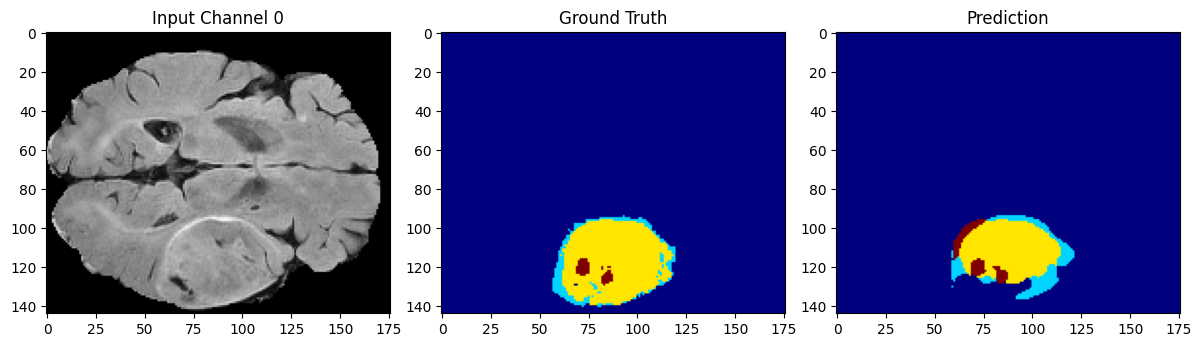

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

# Load one patient image + label
img_path = '/content/imagesTr/BRATS_243.nii.gz'
label_path = '/content/labelsTr/BRATS_243.nii.gz'

img = nib.load(img_path).get_fdata()
label = nib.load(label_path).get_fdata()

slice_index = 60  # choose a relevant axial slice

# Preprocess input
input_slice = img[:, :, slice_index, :2]  # shape: (H, W, 2)
input_slice = np.expand_dims(input_slice, axis=0)  # add batch dim -> (1, H, W, 2)

# Predict
pred = model.predict(input_slice)  # shape: (1, H, W, num_classes)
pred_label = np.argmax(pred[0], axis=-1)  # shape: (H, W)

# Plot result
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_slice[0, :, :, 0], cmap='gray')
plt.title('Input Channel 0')

plt.subplot(1, 3, 2)
plt.imshow(label[:, :, slice_index], cmap='jet')
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(pred_label, cmap='jet')
plt.title('Prediction')

plt.tight_layout()
plt.show()


## 3d pred

Image shape: (144, 176, 144, 2)
Label shape: (144, 176, 144)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1

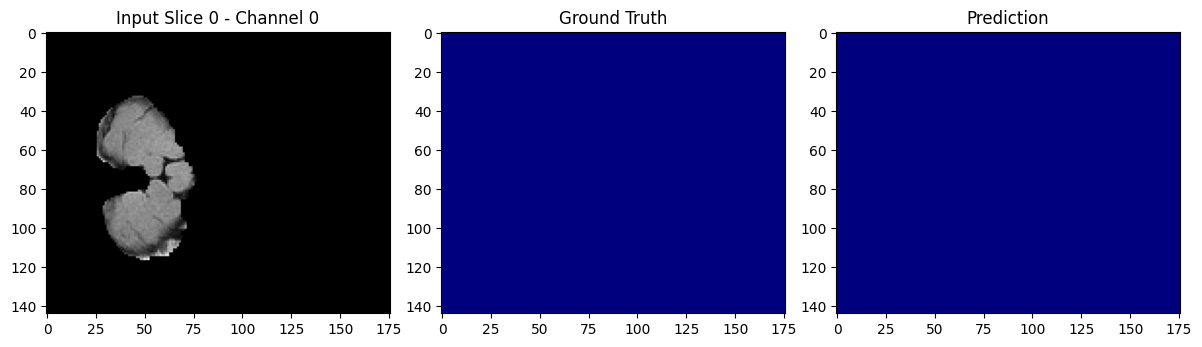

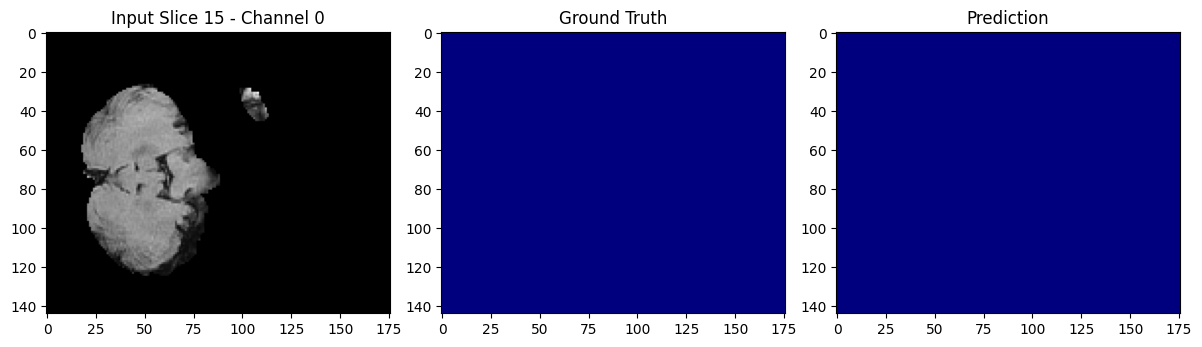

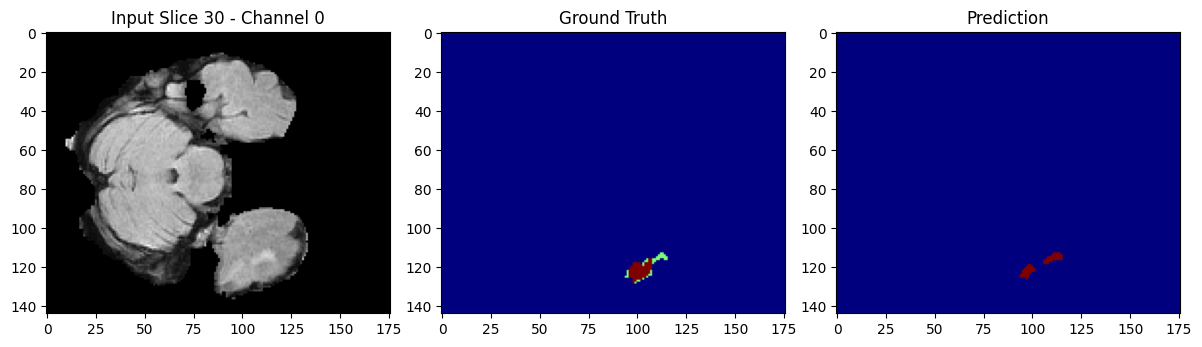

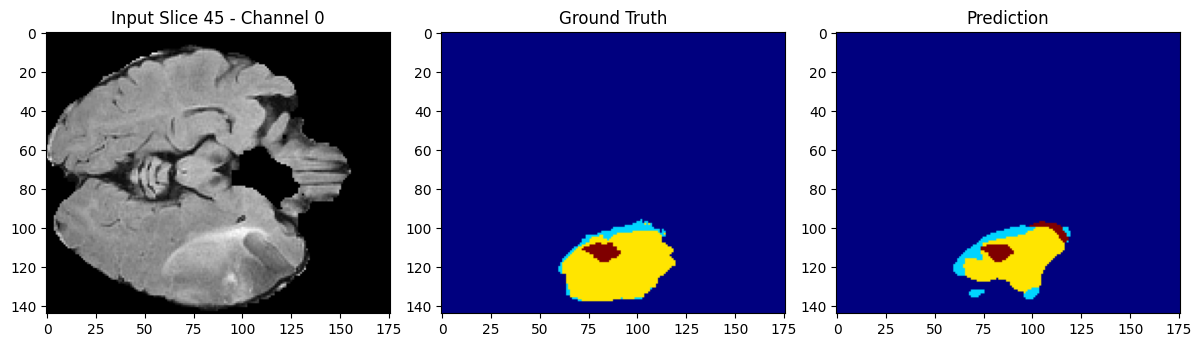

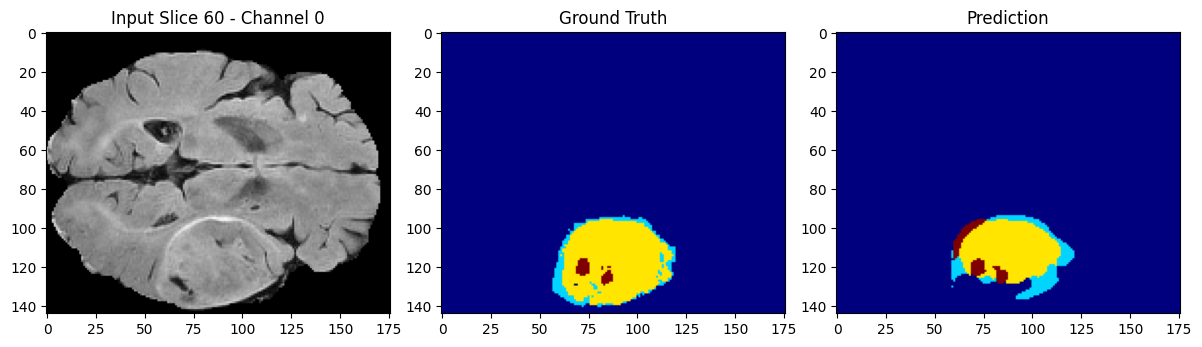

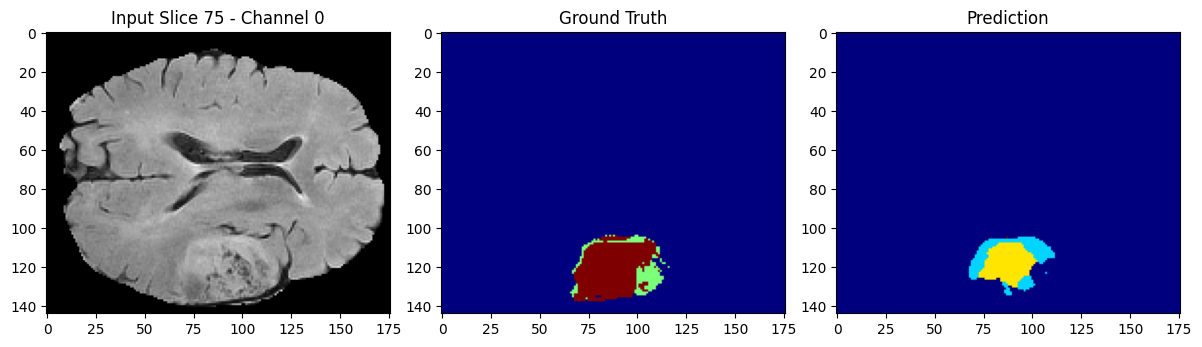

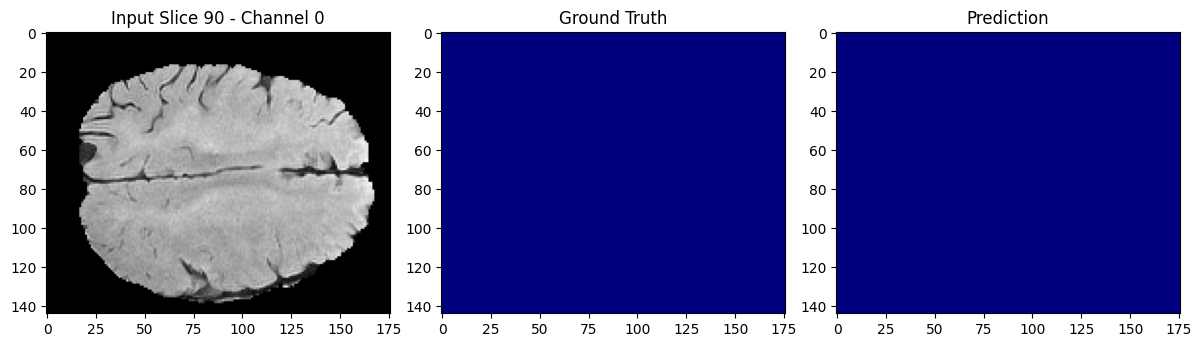

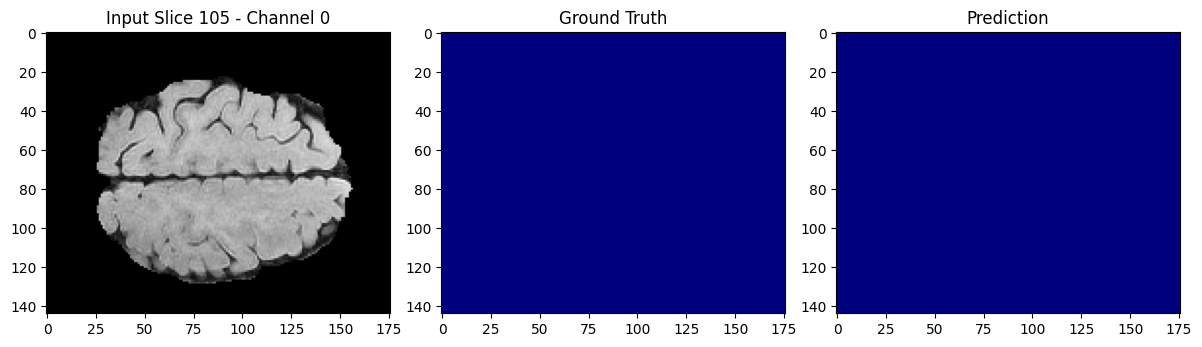

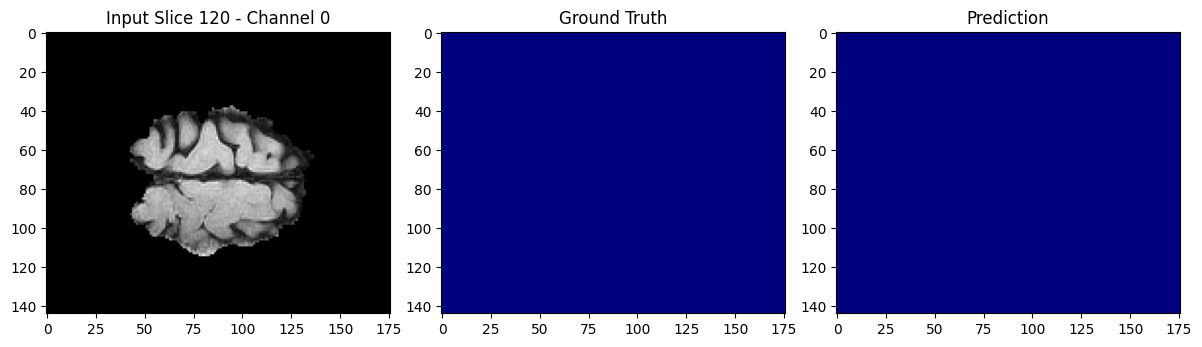

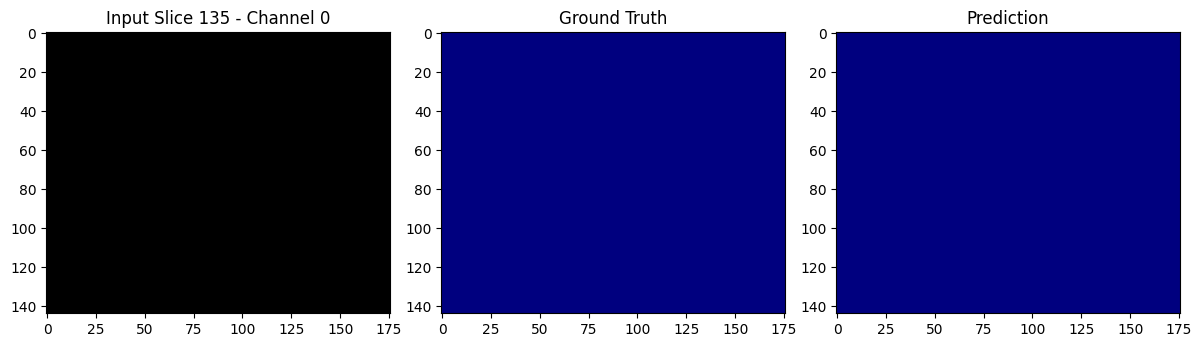

In [39]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Load the 4D image and 3D label
img_path = '/content/imagesTr/BRATS_243.nii.gz'
label_path = '/content/labelsTr/BRATS_243.nii.gz'

img = nib.load(img_path).get_fdata()         # shape: (H, W, D, C)
label = nib.load(label_path).get_fdata()     # shape: (H, W, D)

# Check the dimensions
print(f"Image shape: {img.shape}")  # e.g., (240, 240, 155, 4)
print(f"Label shape: {label.shape}")  # e.g., (240, 240, 155)

# Predict each axial slice
num_slices = img.shape[2]
pred_volume = np.zeros(label.shape, dtype=np.uint8)

for i in range(num_slices):
    input_slice = img[:, :, i, :2]  # use first 2 channels
    input_slice = np.expand_dims(input_slice, axis=0)  # shape: (1, H, W, 2)

    pred = model.predict(input_slice)  # shape: (1, H, W, num_classes)
    pred_label = np.argmax(pred[0], axis=-1)  # shape: (H, W)

    pred_volume[:, :, i] = pred_label

# OPTIONAL: Save prediction to NIfTI
pred_nifti = nib.Nifti1Image(pred_volume, affine=np.eye(4))
nib.save(pred_nifti, '/content/BRATS_243_predicted.nii.gz')

# Plot every 15th slice
for i in range(0, num_slices, 15):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img[:, :, i, 0], cmap='gray')  # channel 0 (e.g. FLAIR)
    plt.title(f'Input Slice {i} - Channel 0')

    plt.subplot(1, 3, 2)
    plt.imshow(label[:, :, i], cmap='jet')
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_volume[:, :, i], cmap='jet')
    plt.title('Prediction')

    plt.tight_layout()
    plt.show()


## Clear session


In [ ]:
del model
del train_data_gen
del validation_data_gen
del history

NameError: name 'model' is not defined

In [ ]:
import tensorflow.keras.backend as K
K.clear_session()


In [ ]:
import gc
gc.collect()


0

# Result analysis (to do)

In [ ]:
import json
import os

# Base path where your history files are
base_path = '/content/drive/MyDrive/final_histories'

# Filenames: combo1.json to combo4.json
history_files = [f'strat_aug_combo{i}.json' for i in range(1, 4)]

# Initialize empty history
full_history = {}

# Loop through each history file
for filename in history_files:
    file_path = os.path.join(base_path, filename)
    with open(file_path, 'r') as f:
        history_part = json.load(f)
        for key, values in history_part.items():
            # Initialize or extend the list
            if key not in full_history:
                full_history[key] = []
            full_history[key].extend(values)


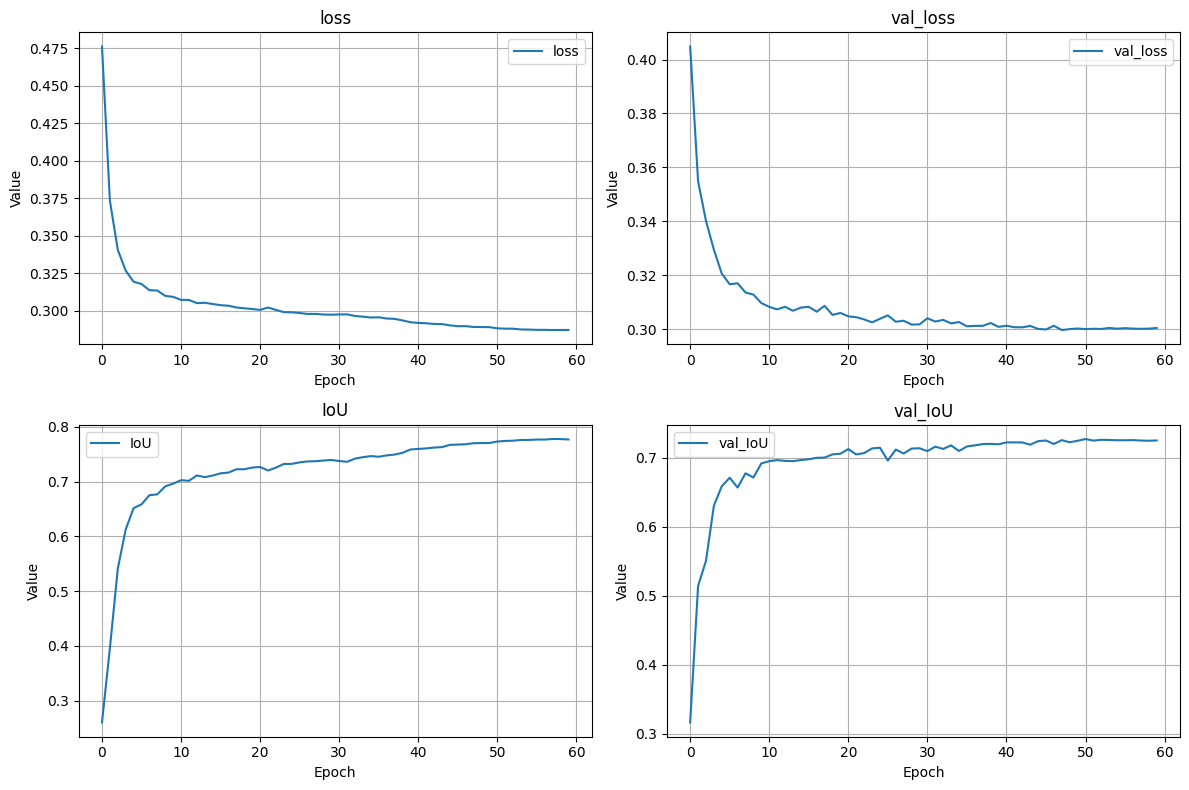

In [ ]:
import matplotlib.pyplot as plt

# Choose which metrics to plot
metrics_to_plot = ['loss', 'val_loss', 'IoU', 'val_IoU']

# Plot
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i+1)
    plt.plot(full_history[metric], label=metric)
    plt.title(metric)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


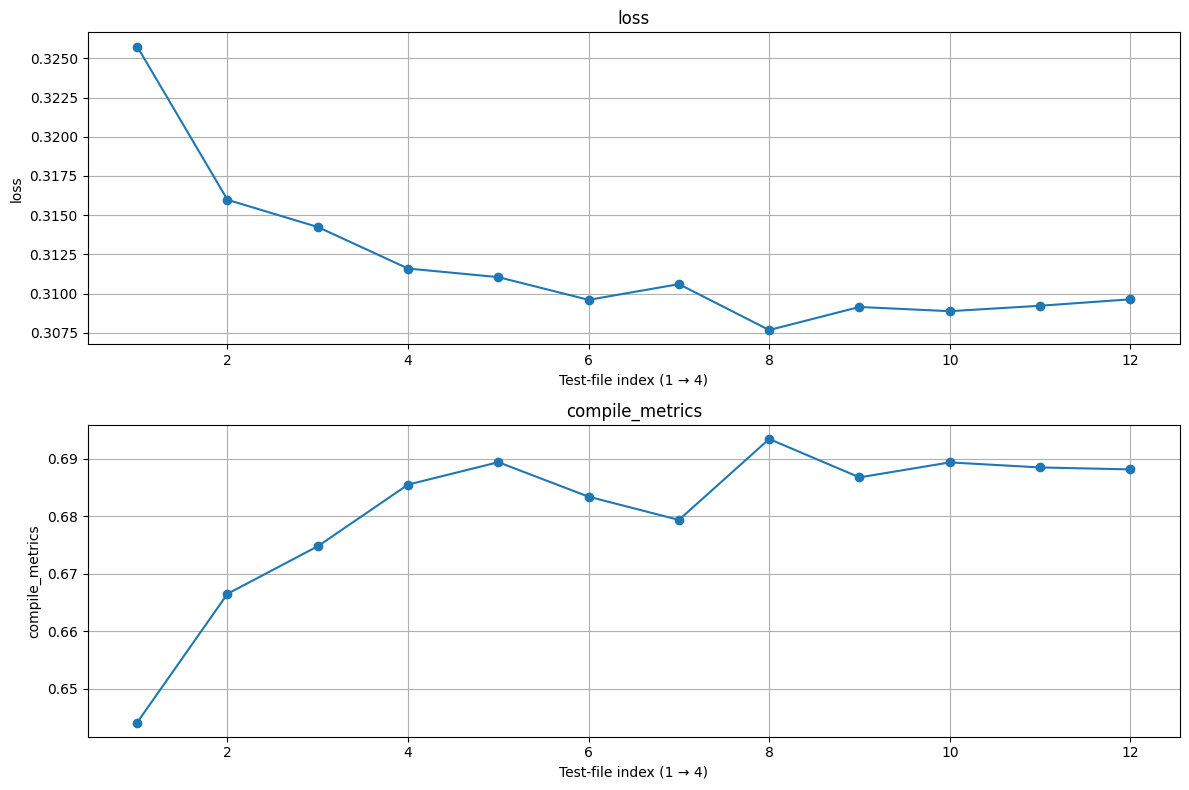

In [ ]:
import json, os, numpy as np
import matplotlib.pyplot as plt

# --- 1. load the JSON files ---------------------------------------------
base_path   = "/content/drive/MyDrive/test_results"
metrics_files = [f"strat_aug_combo{i}.json" for i in range(1, 4)]   # 1→4

metrics_dict = {}          # {'loss': [val1, val2, ...], 'iou': [...]}

for fname in metrics_files:
    fp = os.path.join(base_path, fname)
    with open(fp, "r") as f:
        data = json.load(f)          # ➜ dict: {metric_name: value or list}

    for k, v in data.items():
        # If a value is a list (e.g. per-class scores), average it so each
        # file contributes one number per metric.  Skip this if you want
        # every class plotted separately.
        val = np.mean(v) if isinstance(v, (list, tuple)) else v
        metrics_dict.setdefault(k, []).append(val)

# --- 2. plot every metric -------------------------------------------------
plt.figure(figsize=(12, 4 * len(metrics_dict)))

for i, (metric, values) in enumerate(metrics_dict.items(), 1):
    plt.subplot(len(metrics_dict), 1, i)
    plt.plot(range(1, len(values) + 1), values, marker="o")
    plt.title(metric)
    plt.xlabel("Test-file index (1 → 4)")
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
plt.show()


# ???

In [ ]:
import os
import nibabel as nib
import numpy as np

def compute_class_weights(label_dir, ids_list, num_classes=4):
    class_counts = np.zeros(num_classes, dtype=np.float64)
    total_voxels = 0

    for pid in ids_list:
        label_path = os.path.join(label_dir, pid + '.nii.gz')
        label = nib.load(label_path).get_fdata().astype(np.int32)
        for c in range(num_classes):
            class_counts[c] += np.sum(label == c)
        total_voxels += np.prod(label.shape)

    class_freq = class_counts / total_voxels
    # Avoid division by zero
    class_freq = np.clip(class_freq, 1e-6, None)

    # Compute weights as inverse frequency
    class_weights = 1.0 / class_freq
    # Normalize weights to sum to 1
    class_weights /= np.sum(class_weights)

    return class_weights

    num_classes = 4
weights = compute_class_weights(label_dir, train_ids, num_classes)
class_weights = np.round(weights, 3)  # Round to 3 decimals
print("Class weights:", class_weights)

In [ ]:
def sparse_focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.nn.softmax(y_pred)

        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        cross_entropy = -y_true_one_hot * tf.math.log(y_pred + 1e-6)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return loss

In [ ]:
import os
import numpy as np
import nibabel as nib
from tensorflow.keras.utils import Sequence

class BrainTumor2DSliceGenerator(Sequence):
    def __init__(self, images_folder, labels_folder, ids, batch_size=36, slice_step=8, shuffle=True):

        self.images_folder = images_folder
        self.labels_folder = labels_folder
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.slice_step = slice_step
        self.ids = sorted(ids)
        self.index_list = self._create_index_list()
        if self.shuffle:
            np.random.shuffle(self.index_list)

    def _create_index_list(self):
        index_list = []
        for id in self.ids:
            image_path = os.path.join(self.images_folder, id + '.nii.gz')
            image_data = nib.load(image_path).get_fdata()
            for i in range(0, image_data.shape[2], self.slice_step):
                index_list.append((id, i))
        return index_list

    def __len__(self):
        return int(np.ceil(len(self.index_list) / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.index_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X = []
        batch_y = []
        for id, slice_idx in batch_indexes:
            image_data = nib.load(os.path.join(self.images_folder, id + '.nii.gz')).get_fdata(dtype=np.float32)
            label_data = nib.load(os.path.join(self.labels_folder, id + '.nii.gz')).get_fdata()

            image_slice = image_data[:, :, slice_idx, :]
            label_slice = label_data[:, :, slice_idx]

            batch_X.append(image_slice.astype(np.float32))
            batch_y.append(label_slice.astype(np.int32))

        return np.array(batch_X), np.array(batch_y).astype(np.int32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.index_list)

In [ ]:
gen_no_aug = BrainTumor2DSliceGenerator(
    images_folder,
    labels_folder,
    ids=train_ids,           # or validation_ids
    batch_size=1,
    slice_step=8,
    shuffle=False,
    augment=False
)

gen_with_aug = BrainTumor2DSliceGenerator(
    images_folder,
    labels_folder,
    ids=train_ids,
    batch_size=1,
    slice_step=8,
    shuffle=False,
    augment=True
)


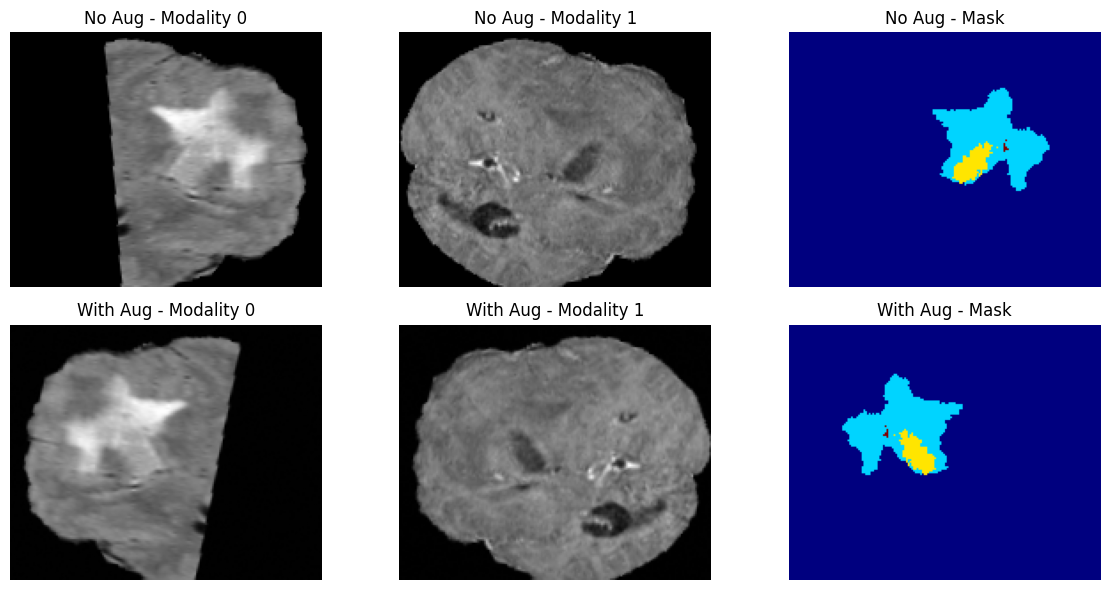

In [ ]:
import matplotlib.pyplot as plt

# Get the same slice from both generators
X_no_aug, y_no_aug = gen_no_aug[80]  # slice_index 60
X_aug, y_aug = gen_with_aug[80]

# Plot and compare
plt.figure(figsize=(12, 6))

# --- No Aug ---
plt.subplot(2, 3, 1)
plt.imshow(X_no_aug[0, :, :, 0], cmap='gray')
plt.title('No Aug - Modality 0')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(X_no_aug[0, :, :, 1], cmap='gray')
plt.title('No Aug - Modality 1')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(y_no_aug[0], cmap='jet')
plt.title('No Aug - Mask')
plt.axis('off')

# --- With Aug ---
plt.subplot(2, 3, 4)
plt.imshow(X_aug[0, :, :, 0], cmap='gray')
plt.title('With Aug - Modality 0')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(X_aug[0, :, :, 1], cmap='gray')
plt.title('With Aug - Modality 1')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(y_aug[0], cmap='jet')
plt.title('With Aug - Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

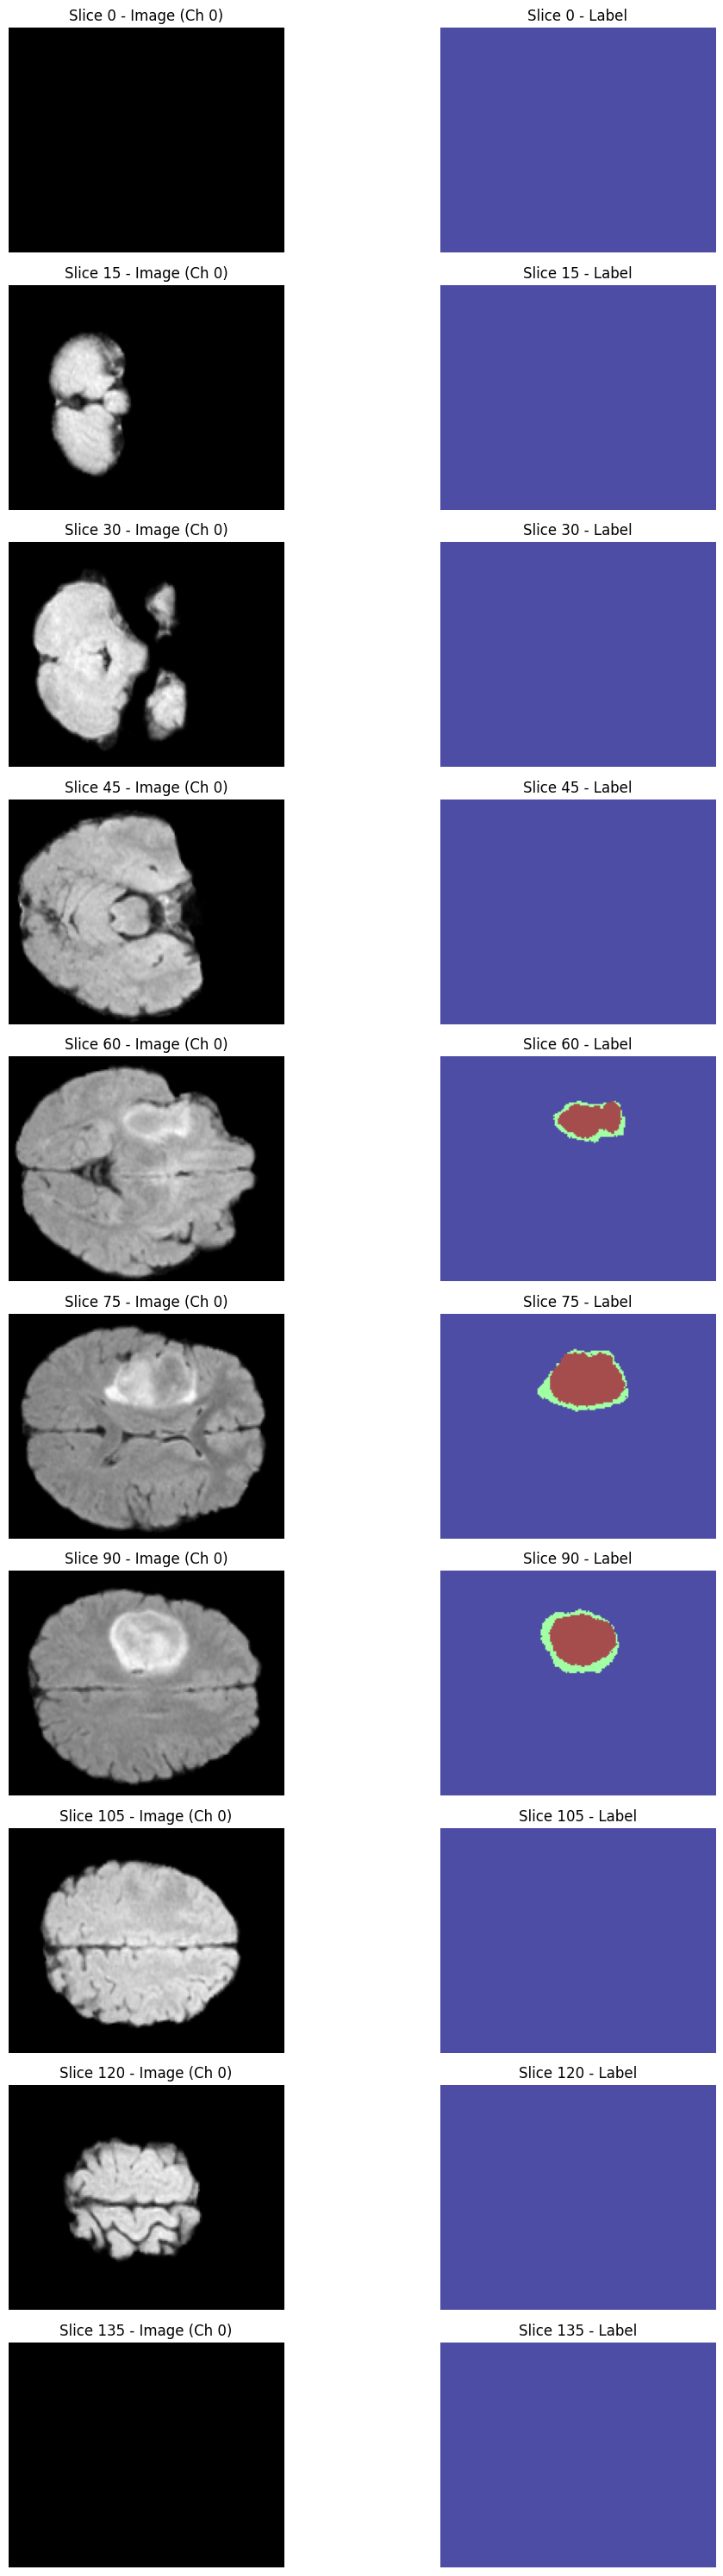

In [ ]:
import os
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

def plot_slices(images_folder, labels_folder, sample_id, slice_step=15):
    # Load image and label volumes
    img_path = os.path.join(images_folder, f"{sample_id}.nii.gz")
    label_path = os.path.join(labels_folder, f"{sample_id}.nii.gz")

    img = nib.load(img_path).get_fdata(dtype=np.float32)  # shape: (H, W, D, C)
    label = nib.load(label_path).get_fdata()              # shape: (H, W, D)

    depth = img.shape[2]

    # Prepare figure
    n_slices = len(range(0, depth, slice_step))
    plt.figure(figsize=(12, 3 * n_slices))

    for i, z in enumerate(range(0, depth, slice_step)):
        plt.subplot(n_slices, 2, 2*i + 1)
        # Plot first channel of image slice (you can change to other channel if needed)
        plt.imshow(img[:, :, z, 0], cmap='gray')
        plt.title(f'Slice {z} - Image (Ch 0)')
        plt.axis('off')

        plt.subplot(n_slices, 2, 2*i + 2)
        plt.imshow(label[:, :, z], cmap='jet', alpha=0.7)
        plt.title(f'Slice {z} - Label')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_slices(images_folder, labels_folder, sample_id='BRATS_026', slice_step=15)
